In [54]:
import sys
import time
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Exceptions')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\DAQ')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\AGI335')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_KIDS_CHAR\Instruments\Gas_Handler22')
from Continuous_Acquisition import ACQUISITION_CONFIG
from Synth import Synthesizer
from logs.logging_config import LOGGING_CONFIG
from logging.config import dictConfig
import logging
import json
from DAQ import DAQ
import niscope as ni
import numpy as np
import matplotlib.pyplot as plt
from AGI335 import AGI335
from Synth.Synthesizer import Synthesizer
import h5py
import datetime
from scipy.signal import savgol_filter, filtfilt, welch
import handler

In [55]:
crio = handler.FridgeHandler()

Creating the object
Cryo handler object created correctly!



In [87]:
MC   = crio.get_sensor()
KPOT = crio.get_sensor(2)
print('1K POT : ',KPOT)
print('Mix Ch : ',MC)

1K POT :  1763.0
Mix Ch :  39.0


In [88]:
def create_hdf5(runfile, I, Q, pulser):
    num_points = ACQUISITION_CONFIG['horizontal']['min_num_pts']
    timestamps = np.linspace(0, num_points/1e6, num_points).astype(np.float64)

    with h5py.File(runfile, 'w') as f:
        group = f.create_group('Signals')
        dset_I   = group.create_dataset('I', data=np.array(I), compression='gzip')
        dset_Q   = group.create_dataset('Q', data=np.array(Q), compression='gzip')
        dset_S21 = group.create_dataset('S21', data=10*np.log10((np.absolute(1j*I+Q)/np.sqrt(2))**2), compression='gzip')
        dset_P   = group.create_dataset('P', data=np.array(Q), compression='gzip')
        dset_timestamp = group.create_dataset('Timestamp', data=np.array(timestamps), compression='gzip')

        # Set attributes for the group
        group.attrs['creation_date'] = str(datetime.datetime.now())
        group.attrs['description'] = 'I and Q signals with timestamps'
        group.attrs['unit'] = 'V'
        group.attrs['num_points'] = num_points
        group.attrs['duration'] = ACQUISITION_CONFIG['acq_conf']['duration']
        group.attrs['sample_rate'] = ACQUISITION_CONFIG['acq_conf']['sample_rate']
        group.attrs['pulser_frequency'] = pulser.frequency
        group.attrs['pulser_duty_cycle'] = pulser.duty_cycle

        # Set attributes for the file
        f.attrs['author'] = 'Riccardo Maifredi'
        f.attrs['project'] = 'IR_Source'
        f.attrs['description'] = 'HDF5 file containing I, Q, and Timestamp signals'

    return f

In [89]:
filepath = r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API'

In [90]:
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

00:19:55.479 - __main__ - <module> - INFO - START EXECUTION


In [91]:
try:
    daq = DAQ.DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')

00:19:55.840 - __main__ - <module> - INFO - DAQ class object correctly created


In [92]:
channels = {'I'			: 0, 
            'Q'			: 1,
            'trigger'	: 1}

In [93]:
devicename =  'Card'

In [94]:
try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

00:19:56.944 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary


In [95]:
try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

00:19:57.280 - __main__ - <module> - INFO - Inserting hconf dic


In [96]:
try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

00:19:57.701 - __main__ - <module> - INFO - Inserting vconf dic


In [97]:
try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

00:19:57.871 - __main__ - <module> - INFO - Inserting chan char dic


In [98]:
try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic') 
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')

00:19:58.137 - __main__ - <module> - INFO - Inserting trigger dic


In [99]:
pulser = AGI335.AGI335()

OBJECT INSTANCE CREATED


In [100]:
board = 'GPIB0::10::INSTR'
pulser.board = board

In [101]:
pulser.connect()
pulser.is_connected

True

In [102]:
pulser.function = 'SQU'
pulser.frequency = 1*1e6
pulser.offset = 0.5
pulser.voltage = 1
pulser.duty_cycle = 16
pulser._pulser.write('SOUR:BURS:STAT ON')
pulser.set_burst_mode()

In [103]:
pulser.duty_cycle

16.0

In [104]:
pulser.trigger_mode = 'BUS'

In [105]:
s1 = Synthesizer()
s1.connettore('ASRL27::INSTR')

In [106]:
f0 = 5.345215443088618
s1.set_frequency(f0)
s1.outp_frequency_on()

In [107]:
pulser.output = 'ON'

In [108]:
print(pulser.output)

ON


In [109]:
devicename = 'PXI1Slot3'

In [110]:
num = 14
save_path = r"C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\14\\"

In [111]:
daq._session = ni.Session(devicename)
daq.configure_channels()
daq.config_trigger()
maxs = []
with daq._session as session:
        for i in range(1000):
                daq._session.initiate()
                pulser.execute_trigger()
                waveforms = session.channels[0,1].fetch()
                f = create_hdf5(save_path+'RUN_'+str(num)+'_PULSE_'+str(i)+'.hdf5', np.array(waveforms[1].samples.tolist()), np.array(waveforms[0].samples.tolist()), pulser)
                maxs.append((min(np.array(waveforms[1].samples.tolist())),np.argmin(np.array(waveforms[1].samples.tolist()))))

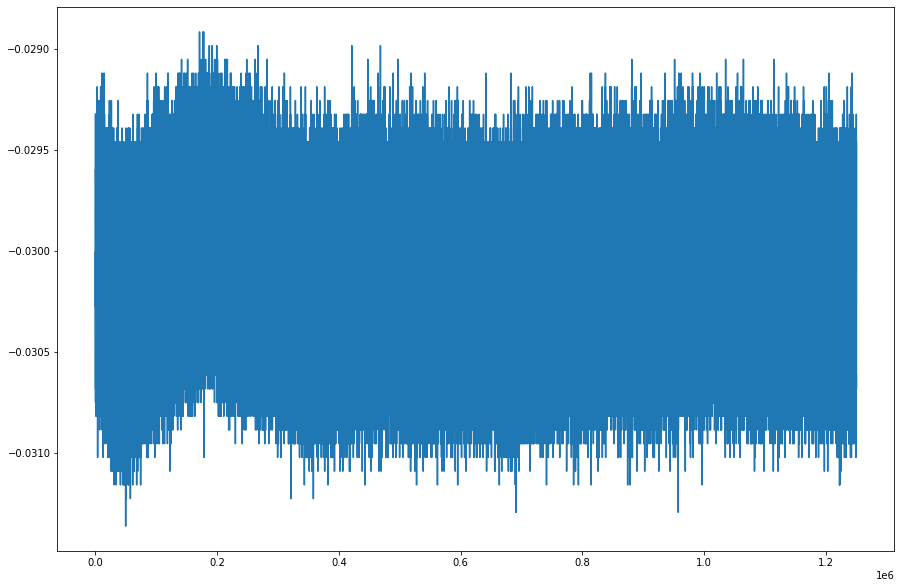

In [112]:
fig = plt.figure(figsize=(15,10))
I = np.array(waveforms[0].samples.tolist())
Q = np.array(waveforms[1].samples.tolist())
S21 = 10*np.log10((np.absolute(1j*I+Q)/np.sqrt(2))**2)
plt.plot(np.linspace(0,len(I),len(I)),I)
#plt.xlim(1*1e5,3*1e5)

In [113]:
mins = [maxs[i][0] for i in range(len(maxs))]

(array([  3.,   1.,  12.,  14.,  17.,  74.,  76., 196., 165., 100., 190.,
         73.,  63.,  13.,   3.]),
 array([0.01374155, 0.01383772, 0.0139339 , 0.01403008, 0.01412626,
        0.01422244, 0.01431862, 0.0144148 , 0.01451098, 0.01460715,
        0.01470333, 0.01479951, 0.01489569, 0.01499187, 0.01508805,
        0.01518423]),
 <BarContainer object of 15 artists>)

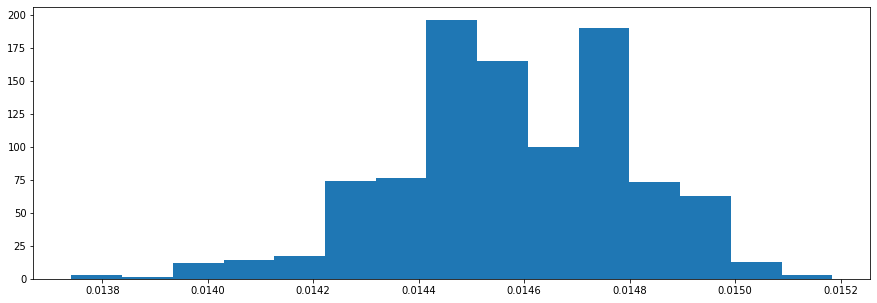

In [114]:
plt.figure(figsize=(15,5))
plt.hist(mins,bins=int(0.5*np.sqrt(len(mins))))